In [1]:
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torchvision.datasets as datasets
import torchvision.transforms as transforms

from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2

In [2]:
root_dir = os.path.join('.', 'data')

if not os.path.exists(root_dir):
    os.mkdir(root_dir)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

dataset = datasets.MNIST(root_dir, train=True, transform=transform, download=True)

In [3]:
data_loader = DataLoader(dataset, shuffle=True, batch_size=64)

In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()
    
    def forward(self, input):
        B, C, H, W = input.size()
        return input.view(B, -1)

    def __repr__(self):
        return self.__class__.__name__ + ' ()'

In [5]:
class SELU(nn.Module):
    def __init__(self, 
                 alpha = 1.6732632423543772848170429916717, 
                 scale = 1.0507009873554804934193349852946, 
                 inplace=False):
        super(SELU, self).__init__()
        self.alpha = alpha
        self.scale = scale
        self.inplace = inplace

    def forward(self, input):
        return self.scale * F.elu(input, self.alpha, self.inplace)

    def __repr__(self):
        inplace_str = ', inplace' if self.inplace else ''
        return self.__class__.__name__ + ' (' \
            + 'alpha=' + str(self.alpha) \
            + ' scale=' + str(self.scale) \
            + inplace_str + ')'

In [6]:
model_selu = nn.Sequential(
    Flatten(),
    nn.Linear(784, 784),
    SELU(inplace=True),
    nn.Linear(784, 784),
    SELU(inplace=True),
    nn.Linear(784, 10)
)

model_relu = nn.Sequential(
    Flatten(),
    nn.Linear(784, 784),
    nn.ReLU(inplace=True),
    nn.Linear(784, 784),
    nn.ReLU(inplace=True),
    nn.Linear(784, 10)
)

model_selu.cuda()
model_relu.cuda()

print(model_selu)
print(model_relu)

Sequential (
  (0): Flatten ()
  (1): Linear (784 -> 784)
  (2): SELU (alpha=1.6732632423543772 scale=1.0507009873554805, inplace)
  (3): Linear (784 -> 784)
  (4): SELU (alpha=1.6732632423543772 scale=1.0507009873554805, inplace)
  (5): Linear (784 -> 10)
)
Sequential (
  (0): Flatten ()
  (1): Linear (784 -> 784)
  (2): ReLU (inplace)
  (3): Linear (784 -> 784)
  (4): ReLU (inplace)
  (5): Linear (784 -> 10)
)


In [7]:
optimizer_selu = optim.SGD(model_selu.parameters(), lr=1e-3)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

In [8]:
def train(images, labels, model, optimizer, criterion):
    optimizer.zero_grad()
    
    images_var = Variable(images).cuda()
    labels_var = Variable(labels, requires_grad=False).cuda()
    
    scores = model(images_var)
    
    loss = criterion(scores, labels_var)
    loss.backward()
    optimizer.step()
    
    return loss.data[0]

In [9]:
num_epochs = 10

selu_losses = []
relu_losses = []

for epoch in range(num_epochs):
    epoch_selu_losses = []
    epoch_relu_losses = []
    
    for data in data_loader:
        images, labels = data
        loss_selu = train(images, labels, model_selu, optimizer_selu, criterion)
        loss_relu = train(images, labels, model_relu, optimizer_relu, criterion)
        
        epoch_selu_losses.append(loss_selu)
        epoch_relu_losses.append(loss_relu)
        
    average_selu_loss = sum(epoch_selu_losses) / float(len(epoch_selu_losses))
    average_relu_loss = sum(epoch_relu_losses) / float(len(epoch_relu_losses))
    
    print('Current Epoch {}: SELU Loss = {} :: RELU Loss = {}'.
          format(epoch+1, average_selu_loss, average_relu_loss))
    
    selu_losses.append(average_selu_loss)
    relu_losses.append(average_relu_loss)

Current Epoch 1: SELU Loss = 1.0846268932130545 :: RELU Loss = 2.020065742260866
Current Epoch 2: SELU Loss = 0.5334115342290671 :: RELU Loss = 1.2203347300415608
Current Epoch 3: SELU Loss = 0.43288363532216817 :: RELU Loss = 0.7158759726263059
Current Epoch 4: SELU Loss = 0.3888318991737325 :: RELU Loss = 0.535969023066543
Current Epoch 5: SELU Loss = 0.3632975288196159 :: RELU Loss = 0.4533534983772713
Current Epoch 6: SELU Loss = 0.34615337338719543 :: RELU Loss = 0.4065817011031769
Current Epoch 7: SELU Loss = 0.33341061198380967 :: RELU Loss = 0.37603055431581
Current Epoch 8: SELU Loss = 0.3234504804984212 :: RELU Loss = 0.3541861929491893
Current Epoch 9: SELU Loss = 0.3152530568240802 :: RELU Loss = 0.33750799067938
Current Epoch 10: SELU Loss = 0.3085152130804336 :: RELU Loss = 0.3240226217503868


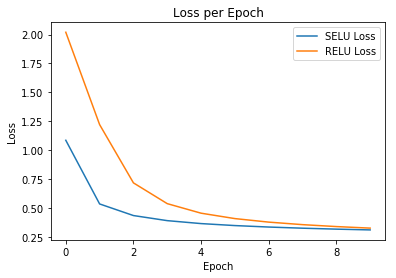

In [10]:
plt.plot(range(len(selu_losses)), selu_losses)
plt.plot(range(len(relu_losses)), relu_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per Epoch')
plt.legend(['SELU Loss', 'RELU Loss'])
plt.show()